In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytz import timezone


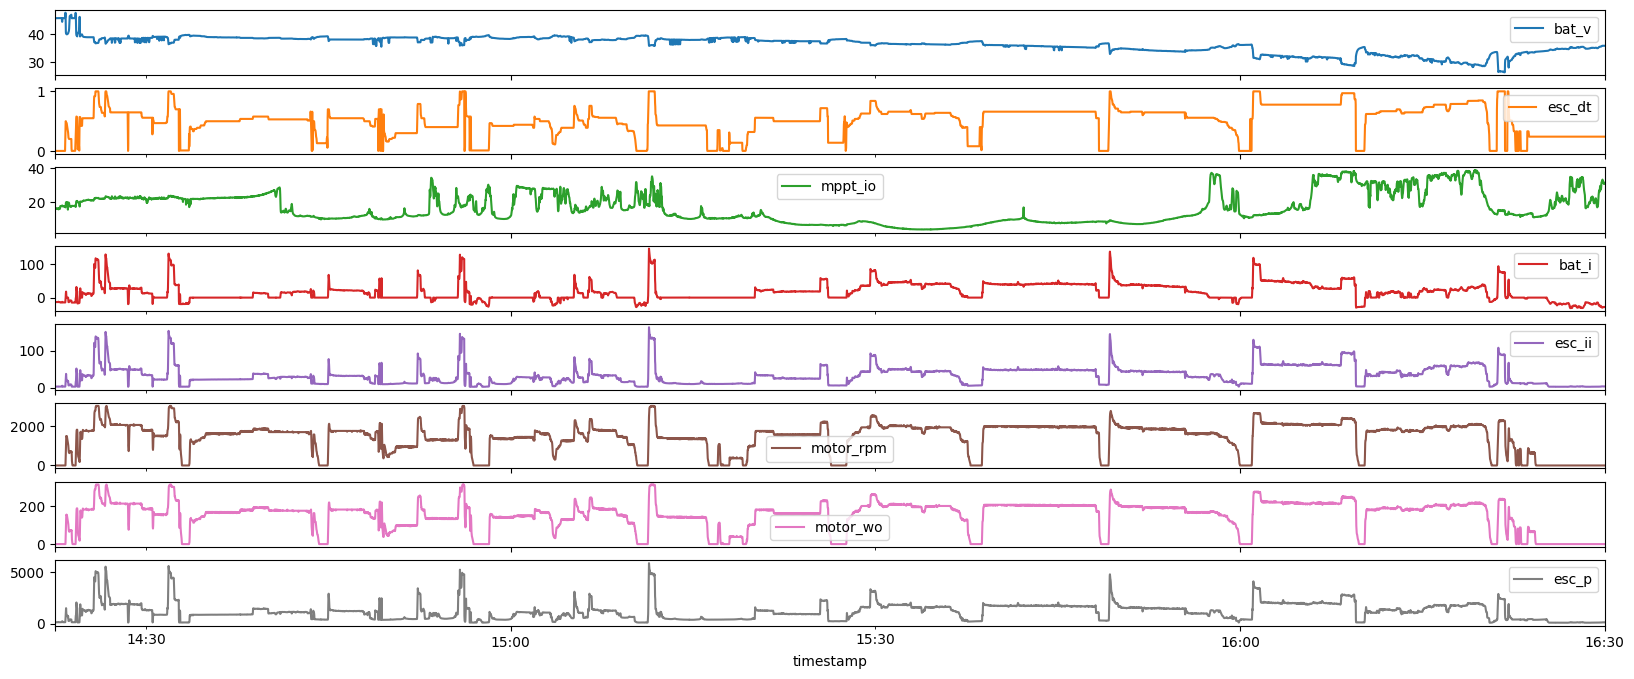

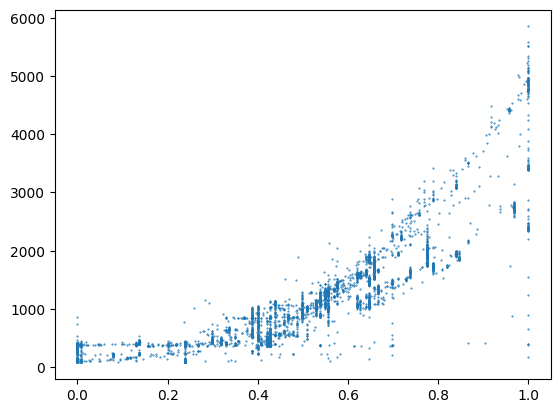

In [288]:
tzinfo = timezone("America/Sao_Paulo")
# start = pd.Timestamp(
#     year=2020, month=1, day=31, hour=12, minute=9, second=0, tzinfo=tzinfo
# ).tz_convert(None)
# end = pd.Timestamp(
#     year=2020, month=1, day=31, hour=12, minute=13, second=0, tzinfo=tzinfo
# ).tz_convert(None)

start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

df = pd.read_csv("../../../models/2020/boat_data_1s.csv")
# df = pd.read_csv("../../../models/2020/boat_data_100ms.csv")
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")

df = df.loc[
    (df.index >= start) & (df.index <= end),
    ["batt_v", "esc_dt", "mppt_i_out", "batt_i", "esc_i_in", "motor_rpm"],
]
# df = df[["batt_v", "esc_dt", "mppt_i_out", "batt_i", "esc_i_in", "motor_rpm"]]
# df = df.dropna()
df = df.interpolate(method="time")

rpm_to_radps = (2 * np.pi) / 60
df["motor_wo"] = df["motor_rpm"] * rpm_to_radps

df['esc_p'] = df['esc_i_in'] * df['batt_v']

df.plot(subplots=True, figsize=(20, 8))
plt.show()

plt.plot()
plt.scatter(df['esc_dt'], df['esc_p'], s=0.2)


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[2428.07725004 -126.12365035]


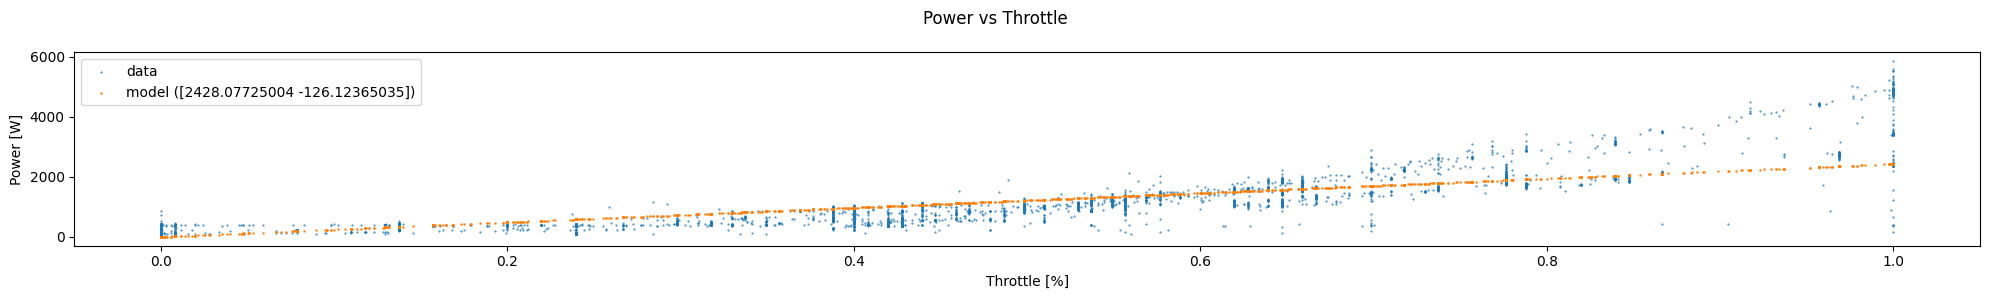

[]

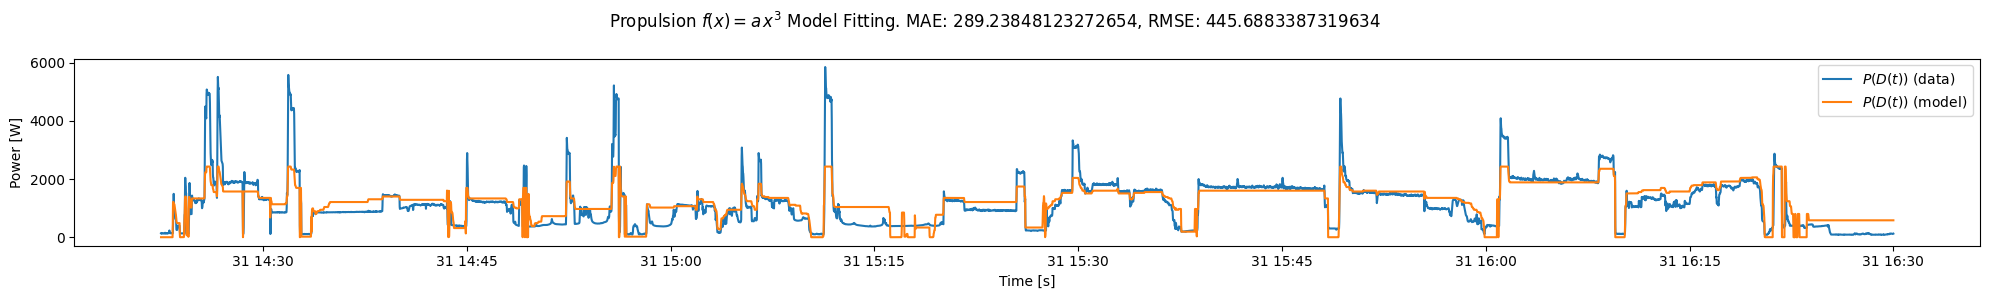

In [298]:
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def esc_p_from_dt(dt, a=5000, b=1):
    b = np.clip(b, 1, 3)
    return a*dt**b

popt, _ = curve_fit(esc_p_from_dt, df['esc_dt'].to_numpy(), df['esc_p'].to_numpy())
print(popt)

esc_p_hat = esc_p_from_dt(df['esc_dt'].to_numpy(), *popt)

df['esc_p_hat'] = esc_p_hat

rmse = (((df['esc_p'].to_numpy() - esc_p_hat)**2).sum() / len(df))**(1/2)
mae = abs(df['esc_p'].to_numpy() - esc_p_hat).sum() / len(df)

plt.figure(figsize=(20,3))
plt.scatter(df['esc_dt'], df['esc_p'], label='data', s=0.2)
plt.scatter(df['esc_dt'], esc_p_hat, label=f'model ({popt})', s=0.5)
plt.xlabel('Throttle [%]')
plt.ylabel('Power [W]')
plt.legend(loc=0)
plt.suptitle('Power vs Throttle')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(df.index, df['esc_p'], label='$P(D(t))$ (data)')
plt.plot(df.index, esc_p_hat, label='$P(D(t))$ (model)')
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.legend(loc=1)
plt.suptitle(f"Propulsion $f(x) = a\,x^3$ Model Fitting. MAE: {mae}, RMSE: {rmse}")
plt.tight_layout()
plt.plot()

[]

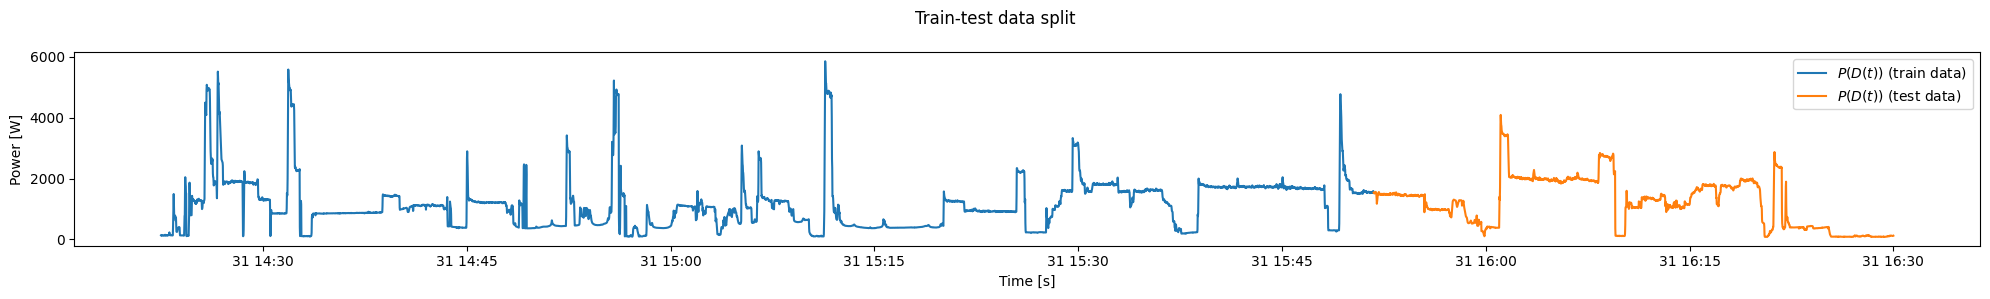

In [249]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from nfoursid.nfoursid import NFourSID

pd.set_option('display.max_columns', None)
np.random.seed(0)  # reproducable results

# Store only useful columns
u_column_names = ["esc_p_hat"]
y_column_names = ["esc_p"]
df = df[[*u_column_names, *y_column_names]]

# Slipt train/test
train_size = int(len(df) * 0.7)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

plt.figure(figsize=(20, 3))
plt.plot(df_train[y_column_names], label='$P(D(t))$ (train data)')
plt.plot(df_test[y_column_names], label='$P(D(t))$ (test data)')
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.legend(loc=1)
plt.suptitle('Train-test data split')
plt.tight_layout()
plt.plot()

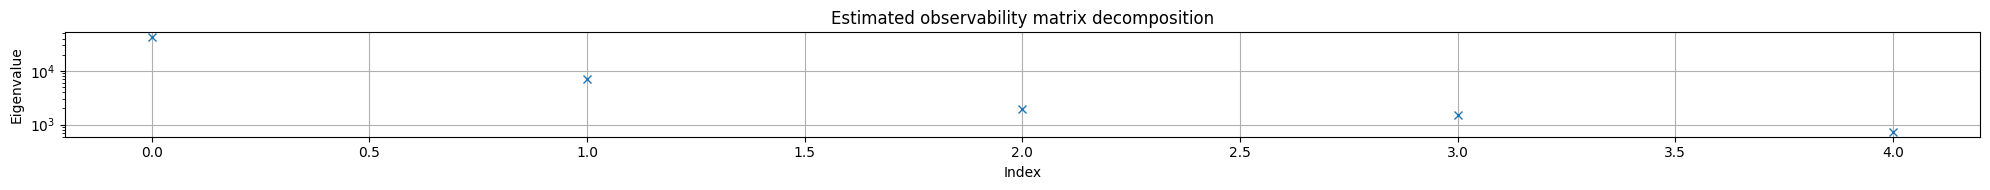

In [250]:
# Create and identify the model
nfoursid = NFourSID(
    df_train,
    output_columns=y_column_names,
    input_columns=u_column_names,
    num_block_rows=5
)
nfoursid.subspace_identification()

fig, ax = plt.subplots(figsize=(20,2))
nfoursid.plot_eigenvalues(ax)
fig.tight_layout()

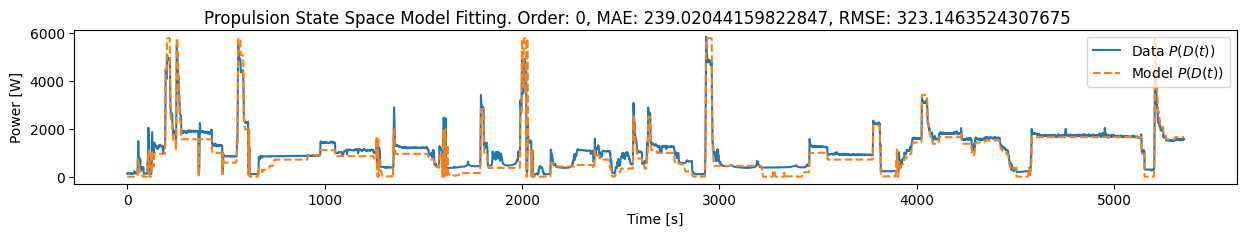

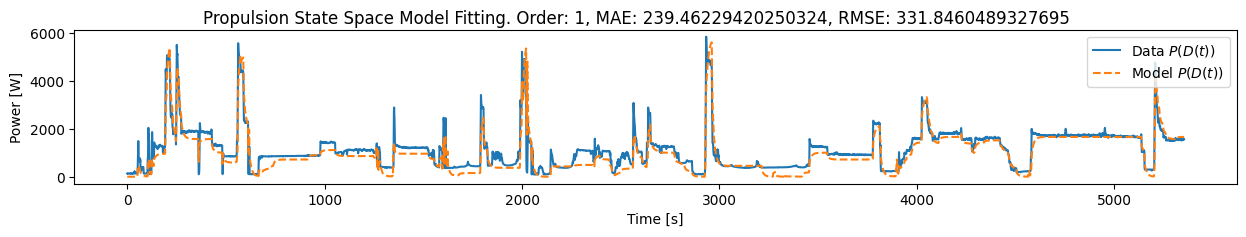

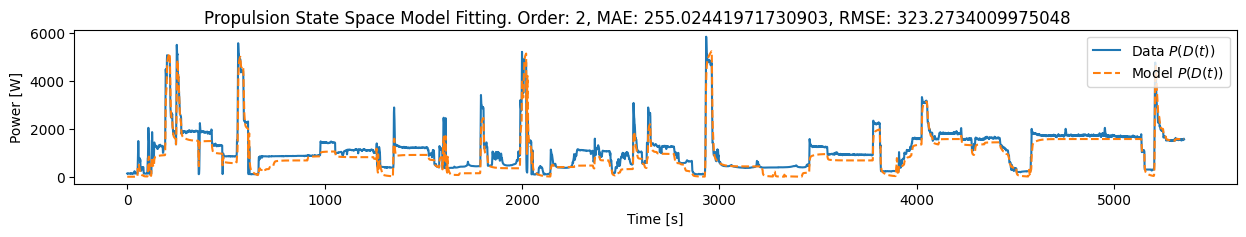

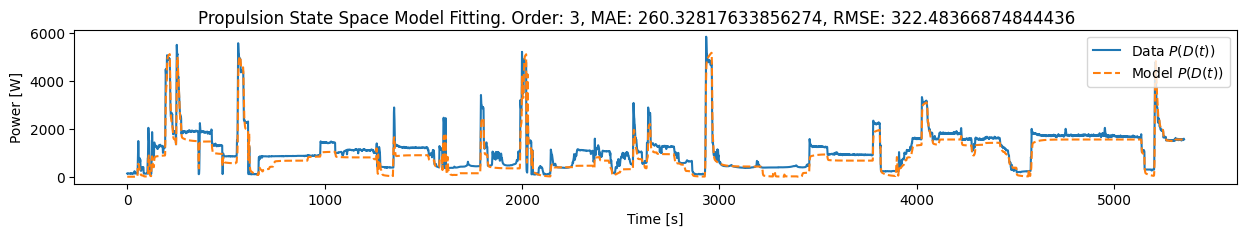

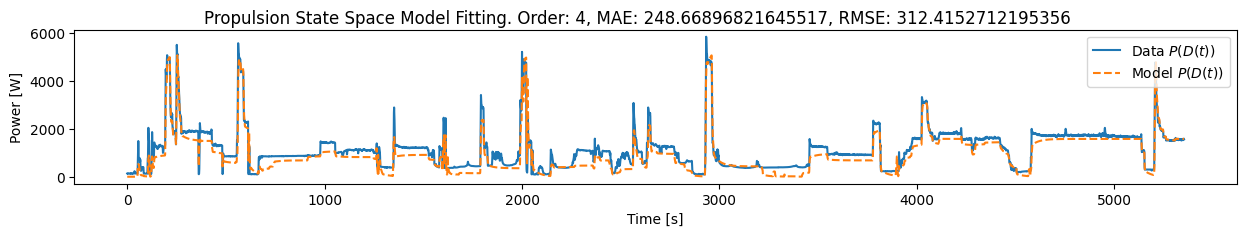

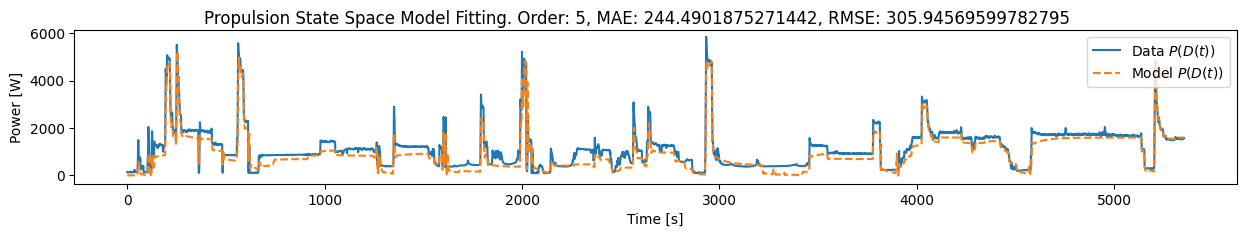

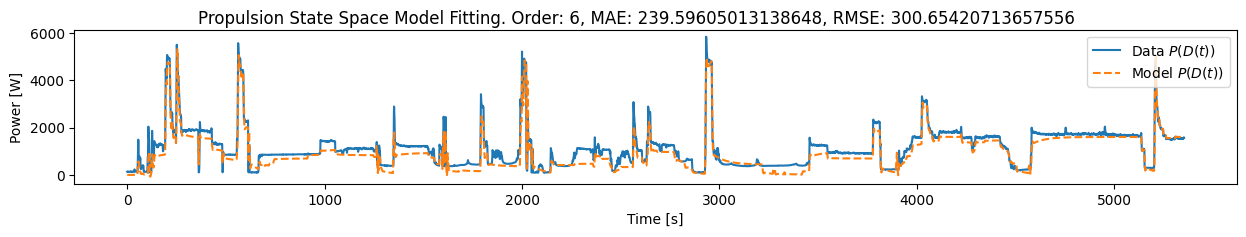

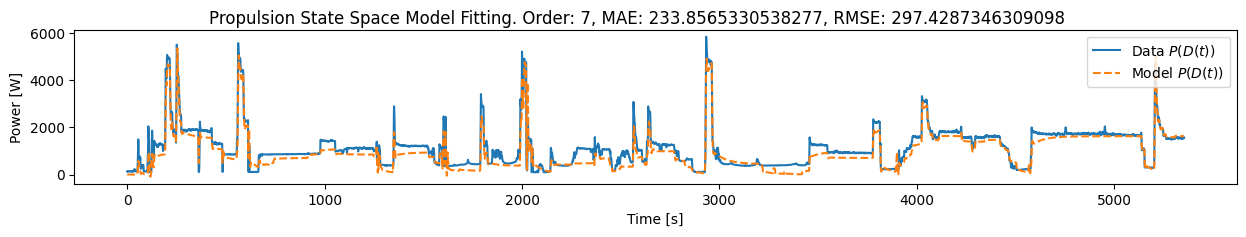

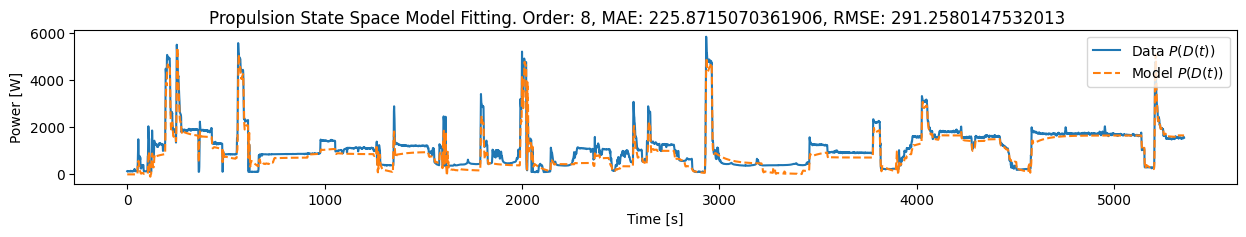

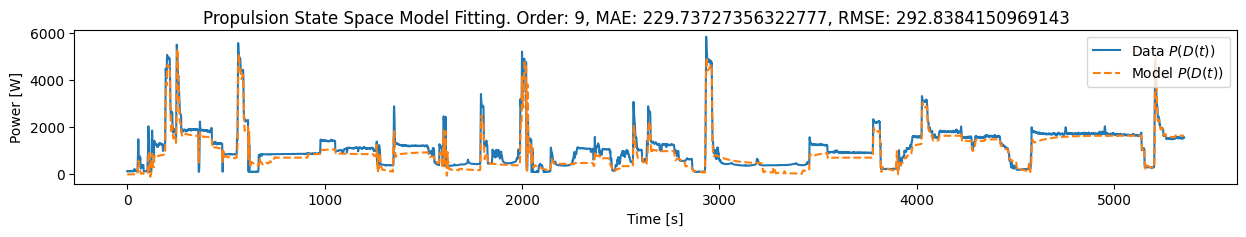

In [251]:
for ORDER_OF_MODEL_TO_FIT in range(10):
    nfoursid = NFourSID(
        df_train,
        output_columns=y_column_names,
        input_columns=u_column_names,
        num_block_rows=ORDER_OF_MODEL_TO_FIT + 2,
    )
    nfoursid.subspace_identification()

    state_space_identified, covariance_matrix = nfoursid.system_identification(
        rank=ORDER_OF_MODEL_TO_FIT
    )

    T = (df_train.index - df_train.index[0]).to_numpy().astype(
        np.float64
    ) * 1e-9  # simulation time in seconds
    U = df_train[[*u_column_names]].to_numpy()
    for i in range(len(U)):
        state_space_identified.step(U[i].reshape(1,1))

    df_pred = state_space_identified.to_dataframe()

    rmse = (((df_train.to_numpy() - df_pred.to_numpy())**2).sum() / len(df_train))**(1/2)
    mae = abs(df_train.to_numpy() - df_pred.to_numpy()).sum() / len(df_train)

    plt.figure(figsize=(15,2))
    plt.plot(T, df_train["esc_p"], label="Data $P(D(t))$")
    plt.plot(T, df_pred["$y_0$"], "--", label="Model $P(D(t))$")
    plt.legend(loc=1)
    plt.suptitle(f"Propulsion State Space Model Fitting. Order: {ORDER_OF_MODEL_TO_FIT}, MAE: {mae}, RMSE: {rmse}")
    plt.xlabel('Time [s]')
    plt.ylabel('Power [W]')
    plt.show()


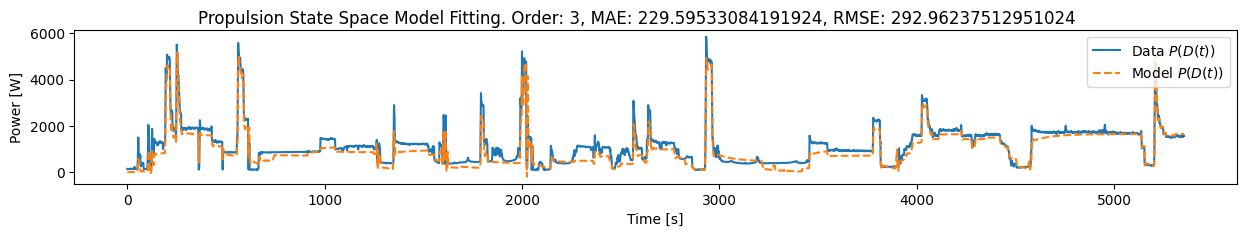

In [284]:
ORDER_OF_MODEL_TO_FIT = 3

nfoursid = NFourSID(
    df_train,
    output_columns=y_column_names,
    input_columns=u_column_names,
    num_block_rows=ORDER_OF_MODEL_TO_FIT + 10,
)
nfoursid.subspace_identification()

state_space_identified, covariance_matrix = nfoursid.system_identification(
    rank=ORDER_OF_MODEL_TO_FIT
)

T = (df_train.index - df_train.index[0]).to_numpy().astype(
    np.float64
) * 1e-9  # simulation time in seconds
U = df_train[[*u_column_names]].to_numpy()
for i in range(len(U)):
    state_space_identified.step(U[i].reshape(1,1))

df_pred = state_space_identified.to_dataframe()

rmse = (((df_train.to_numpy() - df_pred.to_numpy())**2).sum() / len(df_train))**(1/2)
mae = abs(df_train.to_numpy() - df_pred.to_numpy()).sum() / len(df_train)

plt.figure(figsize=(15,2))
plt.plot(T, df_train["esc_p"], label="Data $P(D(t))$")
plt.plot(T, df_pred["$y_0$"], "--", label="Model $P(D(t))$")
plt.legend(loc=1)
plt.suptitle(f"Propulsion State Space Model Fitting. Order: {ORDER_OF_MODEL_TO_FIT}, MAE: {mae}, RMSE: {rmse}")
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.show()


StateSpace(array([[ 0.89828377,  0.15133934, -0.01125819],
       [ 0.29533649,  0.53586078,  0.23811003],
       [ 0.28091979, -0.47773391,  0.94358916]]), array([[-0.00048738],
       [ 0.00149966],
       [ 0.00137638]]), array([[-163.47306286,   99.63165363,    6.66452697]]), array([[0.6011655]]), 0.1)

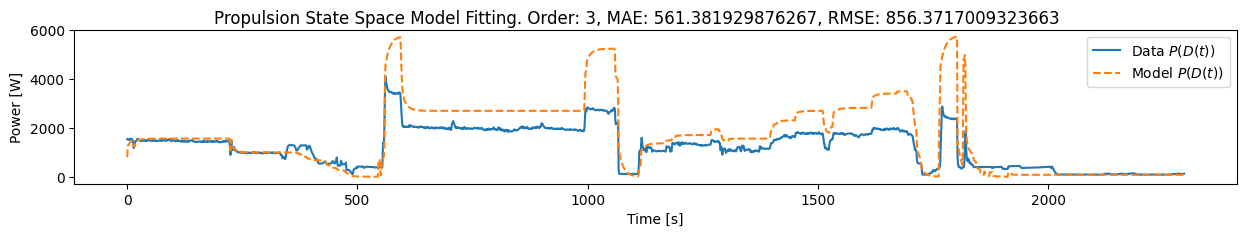

In [285]:
import control as ct

sys = ct.StateSpace(
    state_space_identified.a,
    state_space_identified.b,
    state_space_identified.c,
    state_space_identified.d,
    inputs=u_column_names,
    outputs=y_column_names,
    dt=100e-3,
)
display(sys)

T = (df_test.index - df_test.index[0]).to_numpy().astype(
    np.float64
) * 1e-9  # simulation time in secondsb
U = df_test[[*u_column_names]].to_numpy().T

res = ct.forced_response(sys, T, U=U)
res.output_labels = sys.output_labels
res.input_labels = sys.input_labels
res.state_labels = sys.state_labels
df_pred = res.to_pandas().set_index("time")

rmse = (((df_test[[*y_column_names]].to_numpy() - df_pred[[*y_column_names]].to_numpy())**2).sum() / len(df_test))**(1/2)
mae = abs(df_test[[*y_column_names]].to_numpy() - df_pred[[*y_column_names]].to_numpy()).sum() / len(df_test)

plt.figure(figsize=(15,2))
plt.plot(T, df_test["esc_p"], label="Data $P(D(t))$")
plt.plot(T, df_pred[[*y_column_names]], "--", label="Model $P(D(t))$")
plt.legend(loc=1)
plt.suptitle(f"Propulsion State Space Model Fitting. Order: {ORDER_OF_MODEL_TO_FIT}, MAE: {mae}, RMSE: {rmse}")
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.show()
